In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
from utils import read_ami_SPY_data

In [4]:
train_size = 200
test_size = 5
return_day = 10
extreme_val = 3
full_size = train_size + test_size + return_day 
# make return_day long gap between train and test set to avoid lookahead bias

In [5]:
data = read_ami_SPY_data()

In [6]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [7]:
features_to_delete = data.columns.tolist()

# ROC

In [8]:
for i in [5, 10, 20, 30]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

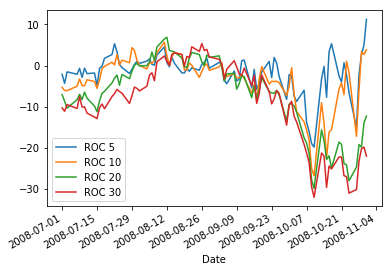

In [9]:
data['2008-07': '2008-10'][['ROC 5', 'ROC 10', 'ROC 20', 'ROC 30']].plot()

# Deviation from zero-lag exponential MA

In [10]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

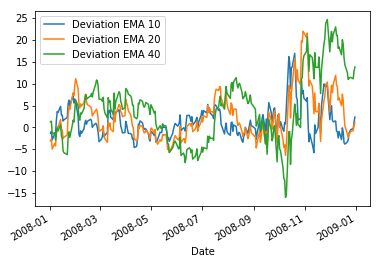

In [11]:
data['2008'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [12]:
for i, j, k in [(14, 20, 12), (12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
#     data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
#     data[f'MACD hist ({i}, {j}, {k})'] = macdhist

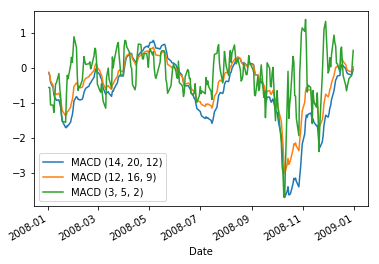

In [13]:
data['2008'][['MACD (14, 20, 12)', 'MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

In [14]:
# data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

In [15]:
# data['2008'][['MACD hist (14, 20, 12)', 'MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [16]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

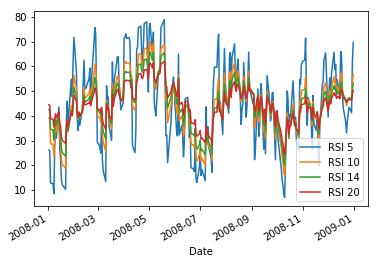

In [17]:
data['2008'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [18]:
for i, j in [(5, 10), (10, 20), (20, 40)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

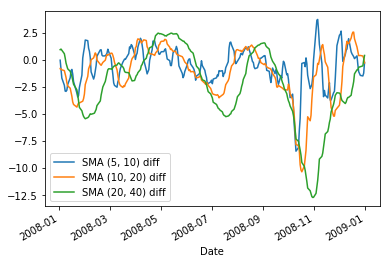

In [19]:
data['2008'][['SMA (5, 10) diff', 'SMA (10, 20) diff', 'SMA (20, 40) diff']].plot()

# ADX

In [20]:
data['ADX 20'] = tl.ADX(high, low, close, timeperiod=20)
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)
data['ADX 7'] = tl.ADX(high, low, close, timeperiod=7)

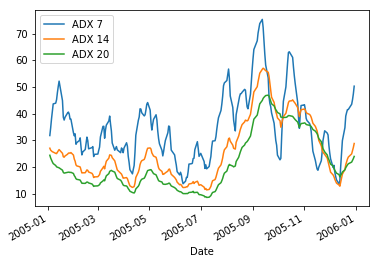

In [21]:
data['2005'][['ADX 7', 'ADX 14', 'ADX 20']].plot()

# CCI

In [22]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

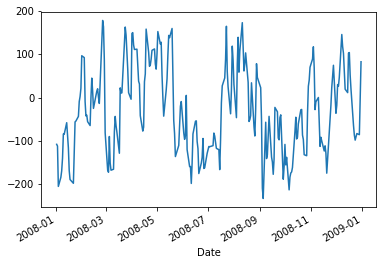

In [23]:
data['2008']['CCI 14'].plot()

# STD deviation 20

In [24]:
data['Std dev 10'] = tl.STDDEV(close, timeperiod=10)
data['Std dev 20'] = tl.STDDEV(close, timeperiod=20)

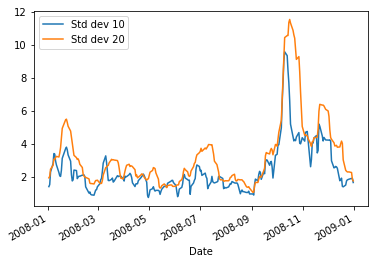

In [25]:
data['2008'][['Std dev 10', 'Std dev 20']].plot()

# Y target value

In [26]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Extreme'] = data['Close'].pct_change(return_day).rolling(return_day).std()*100

In [27]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 5,ROC 10,ROC 20,ROC 30,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (14, 20, 12)","MACD (12, 16, 9)","MACD (3, 5, 2)",...,"SMA (10, 20) diff","SMA (20, 40) diff",ADX 20,ADX 14,ADX 7,CCI 14,Std dev 10,Std dev 20,Return,Extreme
Date,,,,,,,,,,,,,,,,,,,,,
1999-05-05,-0.415512,-0.046339,1.243877,6.835067,-1.793634,-2.853139,-0.432770,0.403900,0.239577,-0.059121,...,0.93594,2.150785,20.440722,20.489020,27.166137,-11.558144,1.199364,1.942356,0.069504,1.336039
1999-05-06,-0.267523,-1.595153,-0.637330,5.577426,-1.750246,-3.248888,-1.433450,0.351419,0.192688,-0.138730,...,0.76172,1.987895,19.525417,19.845702,28.433563,-22.992688,1.221660,1.940844,0.081651,1.642920
1999-05-07,1.313321,-0.598251,0.092678,4.247104,-0.453265,-2.032408,-0.610786,0.344498,0.190961,0.027138,...,0.67422,1.884770,18.655876,19.248335,29.519928,-3.573762,1.197413,1.942808,-1.226889,1.732266
1999-05-10,-1.001861,-1.658642,-1.455773,4.484667,-0.508662,-2.257764,-1.461731,0.309100,0.161892,-0.034079,...,0.54688,1.661723,17.785037,18.298311,28.103513,-26.438913,1.084316,1.888977,-2.384535,1.921237
1999-05-11,1.448598,-1.138434,0.184587,3.454888,0.980149,-0.836615,-0.315329,0.329205,0.186469,0.177762,...,0.37813,1.562503,17.270934,17.280123,24.967837,55.896787,0.789305,1.897725,-4.928604,2.008456


### Features

In [28]:
feature_names = data.drop(['Return', 'Extreme'], axis=1).columns

# Train and test Random Forest

In [29]:
def to_class(y_vec, extreme):
    pos = y_vec > extreme
    neg = y_vec < -1*extreme

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [30]:
def make_X_y(df):
    X = df.drop(['Return', 'Extreme'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y, extreme_val) # df['Extreme']
    return X, y, ret

In [31]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[-test_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[-test_size:]
    train_ret = ret.iloc[:train_size]
    test_ret = ret.iloc[-test_size:]
    print('Split result before upsampling: {} -> {} + {}'.format(len(X), len(X_train), len(X_test)))
    
    last_q4 = int(train_size/4)
    last_q8 = int(train_size/8)
    last_q16 = int(train_size/16)
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:], X_train[-last_q16:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:], y_train[-last_q16:]], ignore_index=True)
    train_ret = pd.concat([train_ret, train_ret[-last_q4:], train_ret[-last_q8:], train_ret[-last_q16:]], ignore_index=True)
    return X_train, X_test, y_train, y_test, train_ret, test_ret

In [32]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [33]:
def calculate_returns(ret, y_pred, log=True):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    if log:
        print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    return ret_sum

In [34]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred, ret):
#     bad_sum     = -8*np.sum(((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos')))
#     np_sum      = -2*np.sum(((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg')))
#     pn_sum      = -1*np.sum(((y_true == 'Pos') & (y_pred == 'Neutral')) | ((y_true == 'Neg') & (y_pred == 'Neutral')))
#     good_sum    =  10*np.sum(((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg')))
#     return bad_sum + np_sum + pn_sum + good_sum
    actual_returns = ret.iloc[y_true.index]
    return calculate_returns(actual_returns, y_pred, log=False) 

In [35]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [36]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, train_ret, test_ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
#                            ('pca', PCA()), 
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [100],
              'forest__max_depth': [3,None],
              'forest__max_features': [3,5],
              'forest__min_samples_split': [2,3,5],
              'forest__min_samples_leaf': [1,2,3],
#               'pca__n_components': [0.3, 0.7]
             }
    scorer = make_scorer(custom_loss, greater_is_better=True, ret=train_ret)
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring=scorer,
                        cv=3)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum = calculate_returns(test_ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.index[-1],
        'best_params': best_params,
        'features': best_estimator.steps[-1][1].feature_importances_,
        'ret_sum': ret_sum
    }
    test_params.append(param)

In [37]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 1999-05-05 00:00:00 to 2000-03-09 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    167
Neg         70
Pos         50
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-05-12 00:00:00 to 2000-03-16 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    169
Neg         62
Pos         56
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         1
        Pos       0.75      0.75      0.75         4

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[0 1]
 [1 3]]
28.97743514045079 [long] + 0.0 [short] = 28.97743514045079
From 1999-05-19 00:00:00 to 2000-03-23 00:00:00
Split result before upsampling: 215 -> 200 + 5
-

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
0.0 [long] + 8.497230461675876 [short] = 8.497230461675876
From 1999-06-10 00:00:00 to 2000-04-13 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    151
Pos         90
Neg         46
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.50      0.25      0.33         4

avg / total       0.40      0.20      0.27         5

---
Confusion matrix
 [[0 1]
 [3 1]]
0.0 [long] + 4.581416784230175 [short] = 4.581416784230175
From 1999-06-17 00:00:00 to 2000-04-20 00:00:00
Split result before 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-06-24 00:00:00 to 2000-04-28 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    146
Pos         75
Neg         66
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.67      0.67      0.67         3
    Neutral       0.50      0.50      0.50         2

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[2 1]
 [1 1]]
0.0 [long] + 10.51089857939208 [short] = 10.51089857939208
From 1999-07-01 00:00:00 to 2000-05-05 00:00:00
Split result before upsampling: 215 -> 200 + 5
-

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         1

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[0 0 0]
 [1 3 0]
 [0 1 0]]
0.0 [long] + 1.2112537186570238 [short] = 1.2112537186570238
From 1999-07-09 00:00:00 to 2000-05-12 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    160
Pos         66
Neg         61
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 1]
 [0 0 4]
 [0 0 0]]
-8.286694301267406 [long] + 0.0 [short] = -8.286694301267406
From 1999-07-16 00:00:00 to 2000-05-19 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    156
Neg         66
Pos         65
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         3
        Pos       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
2.9199921322583977 [long] + 0.0 [short] = 2.9199921322583977
From 1999-07-23 00:00:00 to 2000-05-26 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    161
Pos         66
Neg         60
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
27.522103381418543 [long] + 0.0 [short] = 27.522103381418543
From 1999-07-30 00:00:00 to 2000-06-05 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    171
Pos         64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 3]
 [0 0 0]]
0.39559653938926465 [long] + 0.575245849521111 [short] = 0.9708423889103757
From 1999-08-13 00:00:00 to 2000-06-19 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    160
Pos         77
Neg         50
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 7.568364705196151 [short] = 7.568364705196151
From 1999-08-20 00:00:00 to 2000-06-26 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    157
Pos         84
Neg         46
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
0.0 [long] + 2.3618850199034314 [short] = 2.3618850199034314
From 1999-08-27 00:00:00 to 2000-07-03 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    164
Pos         78
Neg         45
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         2

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [3 0 0]
 [1 1 0]]
0.0 [long] + -11.255570728880437 [short] = -11.255570728880437
From 1999-09-03 00:00:00 to 2000-07-11 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    174
Pos         74
Neg         39
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         1

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [4 0 0]
 [1 0 0]]
0.0 [long] + -4.547184424903339 [short] = -4.547184424903339
From 1999-09-13 00:00:00 to 2000-07-18 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    181
Pos         72
Neg         34
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-09-20 00:00:00 to 2000-07-25 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    183
Pos         74
Neg         30
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-09-27 00:00:00 to 2000-08-01 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    186
Pos         74
Neg         27
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         2
        Pos       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
13.797285822475036 [long] + 0.0 [short] = 13.797285822475036
From 1999-10-04 00:00:00 to 2000-08-08 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    177
Pos         71
Neg         39
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.50      1.00      0.67         1

avg / total       0.10      0.20      0.13         5

---
Confusion matrix
 [[0 0 0]
 [3 0 1]
 [0 0 1]]
5.943238059877576 [long] + -4.917260291241621 [short] = 1.025977768635955
From 1999-10-11 00:00:00 to 2000-08-15 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    178
Pos         69
Neg         40
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.25      0.40         4
        Pos       0.00      0.00      0.00         1

avg / total       0.80      0.20      0.32         5

---
Confusion matrix
 [[0 0 0]
 [3 1 0]
 [1 0 0]]
0.0 [long] + -9.71315871043721 [short] = -9.71315871043721
From 1999-10-18 00:00:00 to 2000-08-22 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    172
Pos         77
Neg         38
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
0.0 [long] + -1.4971711285386213 [short] = -1.4971711285386213
From 1999-10-25 00:00:00 to 2000-08-29 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    183
Pos         69
Neg         35
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.60      0.75         5

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[0 0]
 [2 3]]
0.0 [long] + 0.9913258983890949 [short] = 0.9913258983890949
From 1999-11-01 00:00:00 to 2000-09-06 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    186
Pos         66
Neg         35
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.50      0.67         4
    Neutral       0.33      1.00      0.50         1

avg / total       0.87      0.60      0.63         5

---
Confusion matrix
 [[2 2]
 [0 1]]
0.0 [long] + 9.307546520095311 [short] = 9.307546520095311
From 1999-11-08 00:00:00 to 2000-09-13 00:00:00
Split result befor

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 4 1]
 [0 0 0]
 [0 0 0]]
-3.8514184239972105 [long] + 0.0 [short] = -3.8514184239972105
From 1999-11-15 00:00:00 to 2000-09-20 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    202
Pos         54
Neg         31
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 1 0]
 [0 0 4]
 [0 0 0]]
-5.395070898247278 [long] + 0.0 [short] = -5.395070898247278
From 1999-11-22 00:00:00 to 2000-09-27 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    189
Pos         51
Neg         47
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 2]
 [0 0 3]
 [0 0 0]]
-12.740204035072155 [long] + 0.0 [short] = -12.740204035072155
From 1999-11-30 00:00:00 to 2000-10-04 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    172
Neg         67
Pos         48
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-28.349571257259477 [long] + 0.0 [short] = -28.349571257259477
From 1999-12-07 00:00:00 to 2000-10-11 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    172
Neg         69
Pos         46
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 1]
 [0 0 4]
 [0 0 0]]
-2.597037075398989 [long] + 0.0 [short] = -2.597037075398989
From 1999-12-14 00:00:00 to 2000-10-18 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    174
Neg         69
Pos         44
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         2

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [1 0 2]
 [2 0 0]]
3.9254520672421744 [long] + -13.905609416253517 [short] = -9.980157349011343
From 1999-12-21 00:00:00 to 2000-10-25 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    161
Neg         85
Pos         41
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         4
        Pos       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
12.896673316154917 [long] + 0.0 [short] = 12.896673316154917
From 1999-12-29 00:00:00 to 2000-11-01 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    165
Neg         84
Pos         38
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       1.00      0.50      0.67         4
        Pos       0.00      0.00      0.00         0

avg / total       0.80      0.40      0.53         5

---
Confusion matrix
 [[0 0 1]
 [0 2 2]
 [0 0 0]]
-7.482619988274664 [long] + 0.0 [short] = -7.482619988274664
From 2000-01-05 00:00:00 to 2000-11-08 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    169
Neg         74
Pos         44
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 3 2]
 [0 0 0]
 [0 0 0]]
-9.725265630927616 [long] + 0.0 [short] = -9.725265630927616
From 2000-01-12 00:00:00 to 2000-11-15 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    173
Neg         69
Pos         45
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 2 1]
 [0 0 2]
 [0 0 0]]
-7.034978598273756 [long] + 0.0 [short] = -7.034978598273756
From 2000-01-20 00:00:00 to 2000-11-22 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    175
Neg         67
Pos         45
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 1]
 [0 0 4]
 [0 0 0]]
-2.6649119413023614 [long] + 0.0 [short] = -2.6649119413023614
From 2000-01-27 00:00:00 to 2000-11-30 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    162
Neg         82
Pos         43
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         1

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[3 1]
 [1 0]]
2.025742388758789 [long] + 0.0 [short] = 2.02574238875878

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.67      0.67      0.67         3
    Neutral       1.00      0.50      0.67         2
        Pos       0.00      0.00      0.00         0

avg / total       0.80      0.60      0.67         5

---
Confusion matrix
 [[2 0 1]
 [1 1 0]
 [0 0 0]]
-4.886567177579504 [long] + 12.899365621700499 [short] = 8.012798444120994
From 2000-02-10 00:00:00 to 2000-12-14 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    168
Neg         79
Pos         40
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.50      0.67         2
    Neutral       0.50      0.33      0.40         3
        Pos       0.00      0.00      0.00         0

avg / total       0.70      0.40      0.51         5

---
Confusion matrix
 [[1 1 0]
 [0 1 2]
 [0 0 0]]
-4.173725281885277 [long] + 3.4185749308851987 [short] = -0.7551503510000783
From 2000-02-17 00:00:00 to 2000-12-21 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    170
Neg         74
Pos         43
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.60      0.75         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[3 2]
 [0 0]]
0.07255113081834352 [long] + 0.0 [short] = 0.07255113081834352
From 2000-02-25 00:00:00 to 2000-12-29 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    166
Neg         80
Pos         41
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.60      0.75         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[0 0 0]
 [1 3 1]
 [0 0 0]]
1.2624678418294621 [long] + 1.285310132389872 [short] = 2.547777974219334
From 2000-03-03 00:00:00 to 2001-01-08 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    171
Neg         78
Pos         38
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       1.00      0.33      0.50         3

avg / total       0.60      0.20      0.30         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [0 2 1]]
3.6026006792819087 [long] + -0.18896391410685442 [short] = 3.4136367651750543
From 2000-03-10 00:00:00 to 2001-01-16 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    181
Neg         73
Pos         33
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       1.00      0.33      0.50         3

avg / total       0.60      0.20      0.30         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [1 1 1]]
3.730925892609127 [long] + -9.182312041334818 [short] = -5.451386148725691
From 2000-03-17 00:00:00 to 2001-01-23 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    192
Neg         68
Pos         27
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-03-24 00:00:00 to 2001-01-30 00:00:00
Split result before upsampling: 215 -> 20

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-04-07 00:00:00 to 2001-02-13 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    189
Neg         51
Pos         47
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 4 1]
 [0 0 0]
 [0 0 0]]
-6.283078784212903 [long] + 0.0 [short] = -6.283078784212903
From 2000-04-14 00:00:00 to 2001-02-21 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    192
Neg         51
Pos         44
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 3]
 [0 0 2]
 [0 0 0]]
-18.003148780087717 [long] + 0.0 [short] = -18.003148780087717
From 2000-04-24 00:00:00 to 2001-02-28 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    176
Neg         70
Pos         41
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 1 2]
 [0 0 2]
 [0 0 0]]
-12.791981514875928 [long] + 0.0 [short] = -12.791981514875928
From 2000-05-01 00:00:00 to 2001-03-07 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    163
Neg         87
Pos         37
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-05-08 00:00:00 to 2001-03-14 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    162
Neg         92
Pos         33
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-05-15 00:00:00 to 2001-03-21 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    158
Neg         96
Pos         33
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         0

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[0 1 0]
 [0 3 1]
 [0 0 0]]
-2.6842778014486535 [long] + 0.0 [short] = -2.6842778014486535
From 2000-05-22 00:00:00 to 2001-03-28 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    146
Neg        110
Pos         31
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.50      0.25      0.33         4
        Pos       0.00      0.00      0.00         1

avg / total       0.40      0.20      0.27         5

---
Confusion matrix
 [[0 0 0]
 [3 1 0]
 [0 1 0]]
0.0 [long] + 0.7519643165976642 [short] = 0.7519643165976642
From 2000-05-30 00:00:00 to 2001-04-04 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    149
Neg        112
Pos         26
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-06-06 00:00:00 to 2001-04-11 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    160
Neg        106
Pos         21
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-06-13 00:00:00 to 2001-04-19 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    166
Neg         99
Pos         22
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [2 1 0]]
0.0 [long] + -14.28684074565627 [short] = -14.28684074565627
From 2000-06-20 00:00:00 to 2001-04-26 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    157
Neg         96
Pos         34
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         2

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [3 0 0]
 [2 0 0]]
0.0 [long] + -13.209406674614367 [short] = -13.209406674614367
From 2000-06-27 00:00:00 to 2001-05-03 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    145
Neg         89
Pos         53
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         1

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [4 0 0]
 [1 0 0]]
0.0 [long] + -2.4884074770479936 [short] = -2.4884074770479936
From 2000-07-05 00:00:00 to 2001-05-10 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    143
Neg         82
Pos         62
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         2

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [3 0 0]
 [2 0 0]]
0.0 [long] + -16.100280880320295 [short] = -16.100280880320295
From 2000-07-12 00:00:00 to 2001-05-17 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    147
Neg         76
Pos         64
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 1.0431572036606163 [short] = 1.0431572036606163
From 2000-07-19 00:00:00 to 2001-05-24 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    155
Neg         70
Pos         62
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-07-26 00:00:00 to 2001-06-01 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    156
Neg         66
Pos         65
Name: Retur

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
    Neutral       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
0.0 [long] + 7.417094128794066 [short] = 7.417094128794066
From 2000-08-09 00:00:00 to 2001-06-15 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    178
Neg         59
Pos         50
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.67      1.00      0.80         2
    Neutral       1.00      0.67      0.80         3

avg / total       0.87      0.80      0.80         5

---
Confusion matrix
 [[2 0]
 [1 2]]
0.0 [long] + 9.573474114163316 [short] = 9.573474114163316
From 2000-08-16 00:00:00 to 2001-06-22 00:00:00
Split result before 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 7.157211021452436 [short] = 7.157211021452436
From 2000-08-30 00:00:00 to 2001-07-09 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    153
Neg         94
Pos         40
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
0.0 [long] + 4.014254744333179 [short] = 4.014254744333179
From 2000-09-07 00:00:00 to 2001-07-16 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    163
Neg         89
Pos         35
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
0.0 [long] + 1.7469758895073628 [short] = 1.7469758895073628
From 2000-09-14 00:00:00 to 2001-07-23 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    175
Neg         80
Pos         32
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -2.578627108678777 [short] = -2.578627108678777
From 2000-09-21 00:00:00 to 2001-07-30 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    180
Neg         77
Pos         30
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.60      0.75         5

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[0 0]
 [2 3]]
0.0 [long] + 2.5242062636300244 [short] = 2.5242062636300244
From 2000-09-28 00:00:00 to 2001-08-06 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    189
Neg         69
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         3
    Neutral       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 14.422468650681543 [short] = 14.422468650681543
From 2000-10-05 00:00:00 to 2001-08-13 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    198
Neg         62
Pos         27
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         1
    Neutral       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + 8.363341964630443 [short] = 8.363341964630443
From 2000-10-12 00:00:00 to 2001-08-20 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    200
Neg         60
Pos         27
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-10-19 00:00:00 to 2001-08-27 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    190
Neg         72
Pos         25
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-10-26 00:00:00 to 2001-09-04 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    189
Neg         74
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-11-02 00:00:00 to 2001-09-17 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    189
Neg         74
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-11-09 00:00:00 to 2001-09-24 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    182
Neg         81
Pos         24
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-11-16 00:00:00 to 2001-10-01 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    167
Neg         96
Pos         24
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-11-24 00:00:00 to 2001-10-08 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    158
Neg        105
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.50      0.25      0.33         4
        Pos       0.00      0.00      0.00         1

avg / total       0.40      0.20      0.27         5

---
Confusion matrix
 [[1 3]
 [1 0]]
2.8530799155240594 [long] + 0.0 [short] = 2.8530799155240594
From 2000-12-01 00:00:00 to 2001-10-15 00:00:00
Split result before upsampling: 215 -> 200 + 5

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
2.11729586759527 [long] + 0.0 [short] = 2.11729586759527
From 2000-12-08 00:00:00 to 2001-10-22 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    139
Neg         89
Pos         59
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-12-15 00:00:00 to 2001-10-29 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    144
Neg         82
Pos         61
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.50      1.00      0.67         2
        Pos       0.00      0.00      0.00         3

avg / total       0.20      0.40      0.27         5

---
Confusion matrix
 [[0 0 0]
 [0 2 0]
 [1 2 0]]
0.0 [long] + -4.2624476500698005 [short] = -4.2624476500698005
From 2000-12-22 00:00:00 to 2001-11-05 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    154
Neg         77
Pos         56
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [0 0 0]
 [4 1 0]]
0.0 [long] + -26.81601263528013 [short] = -26.81601263528013
From 2001-01-02 00:00:00 to 2001-11-12 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    160
Neg         74
Pos         53
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-01-09 00:00:00 to 2001-11-19 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    156
Neg         73
Pos         58
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-01-17 00:00:00 to 2001-11-27 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    147
Neg         70
Pos         70
Name: Return, dtype: int64
---
Distributi

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -3.47333820675928 [short] = -3.47333820675928
From 2001-01-24 00:00:00 to 2001-12-04 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    150
Pos         71
Neg         66
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 1.8721086624262084 [short] = 1.8721086624262084
From 2001-01-31 00:00:00 to 2001-12-11 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    160
Pos         67
Neg         60
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.60      0.75         5

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[0 0]
 [2 3]]
0.0 [long] + -1.366006312422563 [short] = -1.366006312422563
From 2001-02-07 00:00:00 to 2001-12-18 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    172
Pos         65
Neg         50
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         1

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [4 0 0]
 [1 0 0]]
0.0 [long] + -8.801548021533634 [short] = -8.801548021533634
From 2001-02-14 00:00:00 to 2001-12-26 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    185
Pos         57
Neg         45
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -6.169095855259821 [short] = -6.169095855259821
From 2001-02-22 00:00:00 to 2002-01-03 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    198
Pos         47
Neg         42
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.20      0.33         5

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[0 0]
 [4 1]]
0.0 [long] + 4.101554880557878 [short] = 4.101554880557878
From 2001-03-01 00:00:00 to 2002-01-10 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    199
Pos         49
Neg         39
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-03-08 00:00:00 to 2002-01-17 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    204
Pos         49
Neg         34
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-03-15 00:00:00 to 2002-01-25 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    208
Pos         48
Neg         31
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-03-22 00:00:00 to 2002-02-01 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    204
Pos         45
Neg         38
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
0.0 [long] + 2.1943775460728454 [short] = 2.1943775460728454
From 2001-03-29 00:00:00 to 2002-02-08 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    206
Neg         42
Pos         39
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.20      0.33         5

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[0 0]
 [4 1]]
0.0 [long] + -3.667813528177921 [short] = -3.667813528177921
From 2001-04-05 00:00:00 to 2002-02-15 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    201
Neg         52
Pos         34
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         1

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [4 0 0]
 [1 0 0]]
0.0 [long] + -5.191003520081027 [short] = -5.191003520081027
From 2001-04-12 00:00:00 to 2002-02-25 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    207
Neg         51
Pos         29
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -31.172256675464656 [short] = -31.172256675464656
From 2001-04-20 00:00:00 to 2002-03-04 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    211
Neg         50
Pos         26
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.50      0.67         2
        Pos       0.00      0.00      0.00         3

avg / total       0.40      0.20      0.27         5

---
Confusion matrix
 [[0 0 0]
 [1 1 0]
 [3 0 0]]
0.0 [long] + -16.095664626422888 [short] = -16.095664626422888
From 2001-04-27 00:00:00 to 2002-03-11 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    213
Neg         46
Pos         28
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-05-04 00:00:00 to 2002-03-18 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    195
Pos         47
Neg         45
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2001-05-11 00:00:00 to 2002-03-25 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    189
Pos         56
Neg         42
Name: Return, dtype: int64
---
Distributi

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
    Neutral       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 11.074192993799937 [short] = 11.074192993799937
From 2001-05-25 00:00:00 to 2002-04-09 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    194
Pos         47
Neg         46
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 3.365749649981764 [short] = 3.365749649981764
From 2001-06-04 00:00:00 to 2002-04-16 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    195
Neg         46
Pos         46
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      1.00      0.89         4
    Neutral       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 16.229375521114775 [short] = 16.229375521114775
From 2001-06-11 00:00:00 to 2002-04-23 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    199
Neg         47
Pos         41
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 21.226298034315317 [short] = 21.226298034315317
From 2001-06-18 00:00:00 to 2002-04-30 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    208
Neg         41


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
0.0 [long] + -1.633974911020164 [short] = -1.633974911020164
From 2001-06-25 00:00:00 to 2002-05-07 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    195
Neg         54
Pos         38
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         2
        Pos       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
12.551843319517264 [long] + 0.0 [short] = 12.551843319517264
From 2001-07-02 00:00:00 to 2002-05-14 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    176
Neg         73
Pos         38
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
2.431725467477275 [long] + 0.0 [short] = 2.431725467477275
From 2001-07-10 00:00:00 to 2002-05-21 00:00:00
Split result before upsampling: 215 -> 200 + 5
---
Distribution:
Neutral    180
Neg         70
Pos         37
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.25      0.50      0.33         2

avg / total       0.10      0.20      0.13         5

---
Confusion matrix
 [[0 3]
 [1 1]]
0.0 [long] + 2.541215046907741 [short] = 2.541215046907741
From 2001-07-17 00:00:00 to 2002-05-29 00:00:00
Split result before 

KeyboardInterrupt: 

In [38]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [39]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [40]:
params.sort_values('Sum of return', ascending=False)

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
2000-03-16,3.0,5,2,3,100,28.977435,0.6
2000-05-26,3.0,3,2,3,100,27.522103,1.0
2002-04-23,3.0,3,3,5,100,21.226298,1.0
2002-04-16,3.0,3,1,3,100,16.229376,0.8
2001-08-06,3.0,3,1,5,100,14.422469,0.6
2000-08-01,3.0,3,1,3,100,13.797286,0.6
2000-10-25,3.0,5,3,5,100,12.896673,0.2
2002-05-07,3.0,5,3,2,100,12.551843,0.6
2002-04-02,3.0,3,2,3,100,11.074193,0.4
2000-04-28,NaN,3,3,2,100,10.510899,0.6


In [41]:
params.describe()

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
count,68.0,111.000000,111.000000,111.000000,111.0,111.000000,111.000000
mean,3.0,3.846847,2.045045,3.261261,100.0,-0.050109,0.335135
std,0.0,0.992684,0.846247,1.211398,0.0,9.129972,0.315839
min,3.0,3.000000,1.000000,2.000000,100.0,-31.172257,0.000000
25%,3.0,3.000000,1.000000,2.000000,100.0,-3.078808,0.000000
50%,3.0,3.000000,2.000000,3.000000,100.0,0.000000,0.200000
75%,3.0,5.000000,3.000000,5.000000,100.0,3.175098,0.600000
max,3.0,5.000000,3.000000,5.000000,100.0,28.977435,1.000000


In [42]:
params['Sum of return'].sum()

-5.5621179106524785

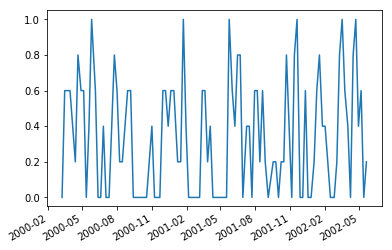

In [43]:
params['Accuracy'].plot()

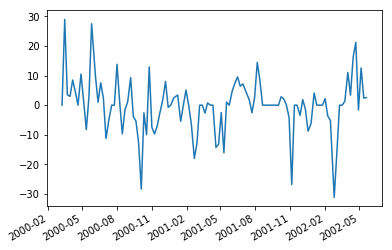

In [44]:
params['Sum of return'].plot()

### Feature importances

In [45]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [46]:
features.idxmax(axis=1).value_counts()

ADX 20               24
Deviation EMA 40     21
SMA (20, 40) diff    17
ADX 14               16
Std dev 10            7
ROC 20                7
RSI 20                6
Std dev 20            4
RSI 14                4
RSI 10                2
MACD (3, 5, 2)        1
CCI 14                1
ROC 30                1
dtype: int64

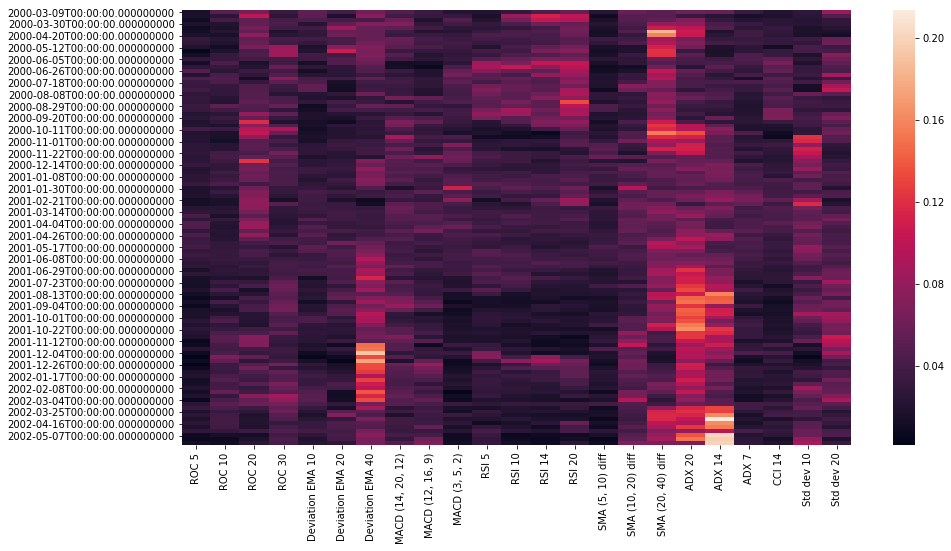

In [47]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


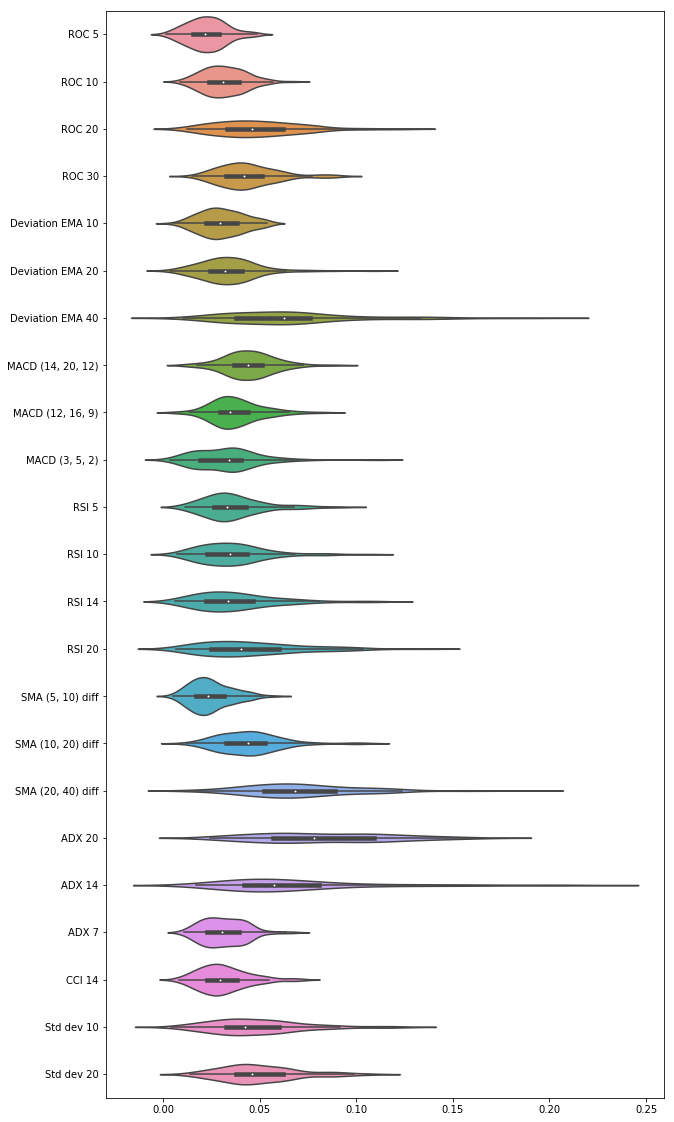

In [48]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')